# 04c - Parity plot for MCMC-sampled structures

This notebook reproduces Fig. 4d from the manuscript. The plot in this notebook compares how good were the predictions of the MACE model used to predict the binding energies of the systems prior to a DFT calculation, and the actual DFT calculation resulting from it.

In [1]:
import itertools
from basics import *
from plotting import *
from plotting import savefig
from ase.io import read
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use("paper")

## Loading the data

In [2]:
root_dir = "../data/04-copper-mcmc"

In [3]:
dset_path = os.path.join(root_dir, "231204_mcmc_sampled.xyz")

dset = read(dset_path, index=":")

full = []
for i, at in enumerate(dset):
    full.append({
        "index": i,
        "crystal_id": at.info["crystal_id"],
        "nads": (at.numbers == 6).sum(),
        "n_atoms": len(at),
        "true": at.info["binding"],
        "pred": at.info["MACE_energy"],
        "facet": at.info["facet"]
    })

full = pd.DataFrame(full)

full["npred"] = full["pred"] / full["nads"]
full["ntrue"] = full["true"] / full["nads"]

## Comparing the predictions (Fig. 4d)

In [4]:
full_metrics = []

for facet, grp in full.groupby("facet"):
    err = grp["npred"] - grp["ntrue"]
    _rmse = np.sqrt((err ** 2).mean())
    full_metrics.append({"facet": facet, "rmse": _rmse})

full_metrics = pd.DataFrame(full_metrics)

In [5]:
err = full["npred"] - full["ntrue"]
rmse = np.sqrt((err ** 2).mean())
print(rmse * 1000)

91.05052545551187


In [6]:
stats.spearmanr(full["ntrue"], full["npred"])

SignificanceResult(statistic=0.9992640961407626, pvalue=0.0)

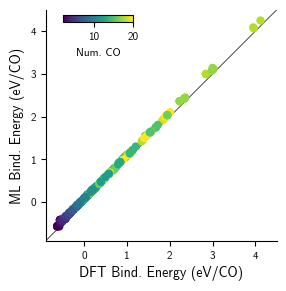

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

norm = plt.Normalize(2, 20)

sc = ax.scatter(
    full["ntrue"], full["npred"],
    c=full["nads"],
    norm=norm,
    linewidths=0.0,
)

lims = [-0.9, 4.5]
ax.plot(lims, lims, "k-", linewidth=0.5, zorder=-1)
ax.set_aspect("equal")
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("DFT Bind. Energy (eV/CO)")
ax.set_ylabel("ML Bind. Energy (eV/CO)")

cax = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(-0.6, 0, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
cbar.set_label("Num. CO", loc="center", fontsize=8)

savefig(fig, "04-mcmc-parity.pdf")
plt.show()